# Classification

[![Index](https://img.shields.io/badge/Index-blue)](../index.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/digillia/Digillia-Colab/blob/main/use-cases/classification.ipynb)

Nous démontrons ici l'usage des algorithmes de classification pour la reconnaissance de nombres écrits à la main.

In [252]:
# Supprimer les commentaires pour installer
# !pip3 install -q -U matplotlib
# !pip3 install -q -U numpy
# !pip3 install -q -U pandas
# !pip3 install -q -U scikit-learn
# !pip3 install -q -U scikit-optimize

## Chargement des Données



In [253]:
import random
import numpy as np
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split

random_state = 42
random.seed(random_state)

# Chargement de la base de données MNIST (OpenML)
# https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
# mnist = fetch_openml('mnist_784', version=1)
# dimension = 28 # 28*28=784

# Chargement d'une base de données plus petite
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html
mnist = load_digits(as_frame=True)
dimension = 8 # 8*8=64

X, y = mnist.data, mnist.target

# Conversion des catégories en nombres entiers
y = y.astype(np.uint8)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=random_state)

# Affichage des dimensions des ensembles d'entraînement et de test
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1540, 64) (1540,) (257, 64) (257,)


## Visualisation des Données

In [254]:
X.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


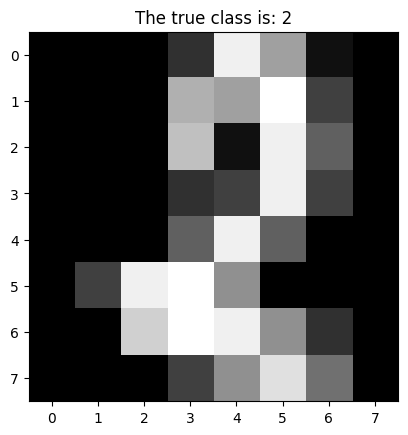

In [267]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Fonction pour afficher un nombre de la base de données
def plot_digit(idx=0, X=X, y=y):
    plt.imshow(np.reshape(X.iloc[idx].to_numpy(), (-1, dimension)), cmap = 'gray');
    plt.title('The true class is: %i' %y.iloc[idx])
    plt.show()

# Afficher un nombre aléatoire de la base de données
idx = random.randint(0, len(X))
plot_digit(idx)

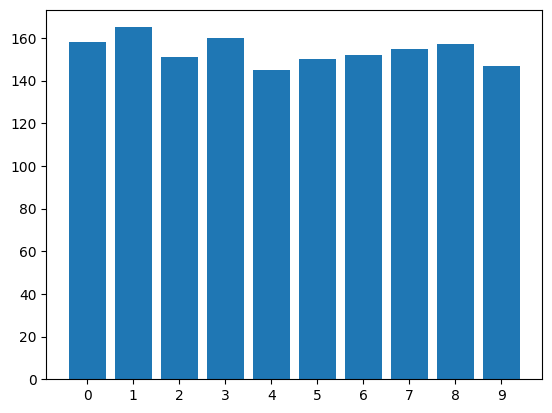

In [284]:
# Histogramme de la répartition du jeu d'entrainement
# pour vérifier que les données sont bien distribuées
# et que les classes sont représentées de manière uniforme

counts = y_train.value_counts()[[0,1,2,3,4,5,6,7,8,9]]

# This does not work in Google Colab
# counts.plot(kind='bar')

# So we do this instead
plt.bar(counts.index, counts.values)
plt.xticks(counts.index)
plt.show()

(array([2., 1., 0., 2., 1., 0., 1., 1., 1., 1.]),
 array([17. , 18.9, 20.8, 22.7, 24.6, 26.5, 28.4, 30.3, 32.2, 34.1, 36. ]),
 <BarContainer object of 10 artists>)

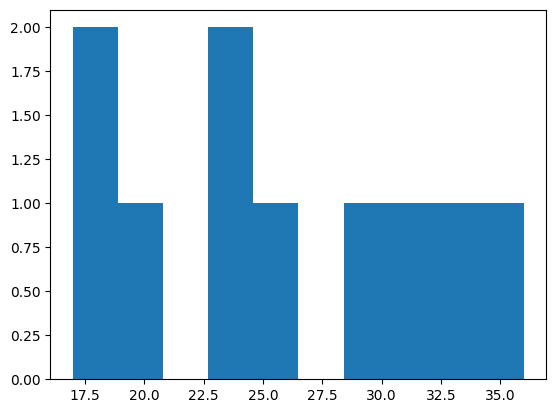

In [268]:
# Histogramme de la répartition du jeu de test
# pour vérifier que les données sont bien distribuées
# et que les classes sont représentées de manière uniforme

counts = y_test.value_counts()[[0,1,2,3,4,5,6,7,8,9]]

# This does not work in Google Colab
# counts.plot(kind='bar')

# So we do this instead
plt.bar(counts.index, counts.values)
plt.xticks(counts.index)
plt.show()

## Essai de Classification avec un Arbre de Décision

In [258]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

clf = DecisionTreeClassifier(random_state=random_state)
clf.fit(X_train, y_train) # ATTENTION! compter des heures avec la base MNIST
y_pred = clf.predict(X_test)

print("Précision de l'Entraînement:", accuracy_score(y_train, clf.predict(X_train)))
print("Précision du Test:", accuracy_score(y_test, y_pred))
print("Score F1 du Test:", f1_score(y_test, y_pred, average='macro'))

Précision de l'Entraînement: 1.0
Précision du Test: 0.8443579766536965
Score F1 du Test: 0.8355581521367238


## Recherche du Meilleur Algorithme

In [259]:
import warnings
import numpy as np
from sklearn.exceptions import ConvergenceWarning
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
    
class DummyEstimator(BaseEstimator):
  def fit(self): pass
  def score(self): pass
        
# Création d'un pipeline avec un estimateur par défaut
pipe = Pipeline([
    ('scaler', MinMaxScaler()), # Comment to avoid ConvergenceWarning
    ('clf', DummyEstimator())
])

# Paramètre de la grille de recherche
param_grid = [
  {
    'clf': [DecisionTreeClassifier(random_state=random_state)],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [2, 3, 4]
  },
  {
     'clf': [LogisticRegression(solver='liblinear', max_iter=300)],
     'clf__penalty': ['l1', 'l2']
  },
  {
    'clf': [GaussianNB()],
    'clf__var_smoothing': [0.1, 1, 10, 100]
  },
  {
    'clf': [GradientBoostingClassifier(n_estimators=200, random_state=random_state)],
    'clf__learning_rate': [0.01, 0.1, 1]
  },
  {
    'clf': [MLPClassifier(max_iter=300, learning_rate='adaptive')],
    'clf__learning_rate_init': [0.001, 0.01, 0.1, 1]
  },
  {
    'clf': [RandomForestClassifier(random_state=random_state)],
    'clf__n_estimators': [10, 50, 100],
    'clf__max_depth': [2, 3, 4]
  },
  {
    'clf': [SVC(kernel='linear', random_state=random_state)],
    'clf__C': [0.1, 1, 10, 100, 1000]
  },
  {
    'clf': [SVC(kernel='rbf', random_state=random_state)],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__decision_function_shape': ['ovo', 'ovr'],
    'clf__gamma': [0.001, 0.01, 0.1, 1],
  }
]

# Création de grille de recherche
gs = GridSearchCV(
  estimator=pipe,
  param_grid=param_grid,
  scoring='accuracy',
  cv=5,
  n_jobs=-1, # Répartition sur tous les processeurs
  refit=True,
  return_train_score=True,
  verbose=2
)

# Entraînement de la grille de recherche
# MinMaxScaler raises some ConvergenceWarning which we ignore
# because they yield a slightly better score in the end
with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
  gs.fit(X_train, y_train)  # ATTENTION! compter des heures avec la base MNIST

Fitting 5 folds for each of 73 candidates, totalling 365 fits
[CV] END clf=DecisionTreeClassifier(random_state=42), clf__criterion=gini, clf__max_depth=3; total time=   0.0s
[CV] END clf=DecisionTreeClassifier(random_state=42), clf__criterion=gini, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeClassifier(random_state=42), clf__criterion=gini, clf__max_depth=3; total time=   0.0s
[CV] END clf=DecisionTreeClassifier(random_state=42), clf__criterion=gini, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeClassifier(random_state=42), clf__criterion=gini, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeClassifier(random_state=42), clf__criterion=gini, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeClassifier(random_state=42), clf__criterion=gini, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeClassifier(random_state=42), clf__criterion=gini, clf__max_depth=3; total time=   0.0s
[CV] END clf=DecisionTreeClassifier(random

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=2, clf__n_estimators=50; total time=   0.1s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=2, clf__n_estimators=100; total time=   0.1s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=2, clf__n_estimators=50; total time=   0.1s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=2, clf__n_estimators=50; total time=   0.1s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=2, clf__n_estimators=100; total time=   0.1s
[CV] END clf=MLPClassifier(learning_rate='adaptive', max_iter=300), clf__learning_rate_init=0.01; total time=   0.4s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=2, clf__n_estimators=100; total time=   0.2s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=3, clf__n_estimators=10; total time=   0.0s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=2, clf__n_estimators

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=3, clf__n_estimators=100; total time=   0.1s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=4, clf__n_estimators=10; total time=   0.0s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=4, clf__n_estimators=10; total time=   0.0s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=4, clf__n_estimators=10; total time=   0.0s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=4, clf__n_estimators=50; total time=   0.1s
[CV] END clf=RandomForestClassifier(random_state=42), clf__max_depth=4, clf__n_estimators=100; total time=   0.2s
[CV] END clf=SVC(kernel='linear', random_state=42), clf__C=0.1; total time=   0.0s
[CV] END clf=SVC(kernel='linear', random_state=42), clf__C=1; total time=   0.0s
[CV] END clf=SVC(kernel='linear', random_state=42), clf__C=1; total time=   0.0s
[CV] END clf=SVC(kernel='linear', random_state=42), clf__C=1; total time=  

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=MLPClassifier(learning_rate='adaptive', max_iter=300), clf__learning_rate_init=0.001; total time=   1.3s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.1; total time=   0.3s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.001; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.001; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.1; total time=   0.1s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.01; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.001; total time=   0.4s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.1; total time=   0.3s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_fu

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=1; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=1; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.01; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovr, clf__gamma=0.01; total time=   0.3s
[CV] END clf=GradientBoostingClassifier(n_estimators=200, random_state=42), clf__learning_rate=1; total time=   2.4s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=1; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovr, clf__gamma=0.001; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_shape=ovo, clf__gamma=0.01; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=0.1, clf__decision_function_sh

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovr, clf__gamma=0.01; total time=   0.1s
[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovr, clf__gamma=1; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovr, clf__gamma=0.001; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovo, clf__gamma=0.001; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovr, clf__gamma=0.01; total time=   0.1s
[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovo, clf__gamma=1; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovr, clf__gamma=1; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovr, clf__gamma=0.001; total time=   0.2s
[CV] END clf=SVC(random_state=42), clf__C=1, clf__decision_function_shape=ovr, clf__ga

In [260]:
# Résultats de la grille de recherche
import pandas as pd
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['rank_test_score', 'param_clf', 'params', 'mean_train_score', 'mean_test_score']].head()

,rank_test_score,param_clf,params,mean_train_score,mean_test_score
63,1,SVC(random_state=42),"{'clf': SVC(random_state=42), 'clf__C': 100, '...",1.0,0.992208
59,1,SVC(random_state=42),"{'clf': SVC(random_state=42), 'clf__C': 100, '...",1.0,0.992208
67,1,SVC(random_state=42),"{'clf': SVC(random_state=42), 'clf__C': 1000, ...",1.0,0.992208
71,1,SVC(random_state=42),"{'clf': SVC(random_state=42), 'clf__C': 1000, ...",1.0,0.992208
55,5,SVC(random_state=42),"{'clf': SVC(random_state=42), 'clf__C': 10, 'c...",1.0,0.991558


In [261]:
print('Meilleur Score:', gs.best_score_)
print(gs.best_estimator_)

Meilleur Score: 0.9922077922077921
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 SVC(C=100, decision_function_shape='ovo', gamma=0.1,
                     random_state=42))])


## Recherche des Meilleurs Paramètres (HyperTuning)

In [262]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer # Categorical

estimator = Pipeline([
  ('scaler', MinMaxScaler()),
  ('svm', SVC(decision_function_shape='ovo', random_state=random_state))
])

search_spaces = {
  'svm__C': Real(1e-6, 1e+6, prior='log-uniform'),
  'svm__degree': Integer(1,8),
  'svm__gamma': Real(1e-6, 1e+1, prior='log-uniform')
}

bs = BayesSearchCV(
  estimator=estimator,
  search_spaces=search_spaces,
  scoring='accuracy',
  n_iter=50,
  n_jobs=-1,
  cv=5,
  verbose=2,
  random_state=random_state
)

# Fixes the issue: AttributeError: module 'numpy' has no attribute 'int'.
np.int = int

# executes bayesian optimization
bs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svm__C=0.08341564384216595, svm__degree=6, svm__gamma=3.389034515643755; total time=   0.2s
[CV] END svm__C=0.08341564384216595, svm__degree=6, svm__gamma=3.389034515643755; total time=   0.2s
[CV] END svm__C=0.08341564384216595, svm__degree=6, svm__gamma=3.389034515643755; total time=   0.2s
[CV] END svm__C=0.08341564384216595, svm__degree=6, svm__gamma=3.389034515643755; total time=   0.2s
[CV] END svm__C=0.08341564384216595, svm__degree=6, svm__gamma=3.389034515643755; total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svm__C=11185.625288472094, svm__degree=7, svm__gamma=0.00013300585802877296; total time=   0.0s
[CV] END svm__C=11185.625288472094, svm__degree=7, svm__gamma=0.00013300585802877296; total time=   0.0s
[CV] END svm__C=11185.625288472094, svm__degree=7, svm__gamma=0.00013300585802877296; total time=   0.0s
[CV] END svm__C=11185.625288472094, svm__degree=7, svm__gamma=

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                        ('svm',
                                         SVC(decision_function_shape='ovo',
                                             random_state=42))]),
              n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'svm__C': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='normalize'),
                             'svm__degree': Integer(low=1, high=8, prior='uniform', transform='normalize'),
                             'svm__gamma': Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize')},
              verbose=2)

In [263]:
print('Meilleur score:', bs.best_score_)
print(bs.best_estimator_)

Meilleur score: 0.9928571428571429
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svm',
                 SVC(C=37.88074657943293, decision_function_shape='ovo',
                     degree=7, gamma=0.09475324187657397, random_state=42))])


## Implémentation de la Solution Optimale

In [264]:
C=37.88074657943293
decision_function_shape='ovo'
degree=7
gamma=0.09475324187657397

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svc', SVC(C=C, decision_function_shape=decision_function_shape, degree=degree, gamma=gamma, random_state=random_state))
])

clf.fit(X_train, y_train) # ATTENTION! compter des heures avec la base MNIST
y_pred = clf.predict(X_test)

print("Précision de l'Entraînement:", accuracy_score(y_train, clf.predict(X_train)))
print("Précision du Test:", accuracy_score(y_test, y_pred))
print("Score F1 du Test:", f1_score(y_test, y_pred, average='macro'))

Précision de l'Entraînement: 1.0
Précision du Test: 0.9844357976653697
Score F1 du Test: 0.984520202020202


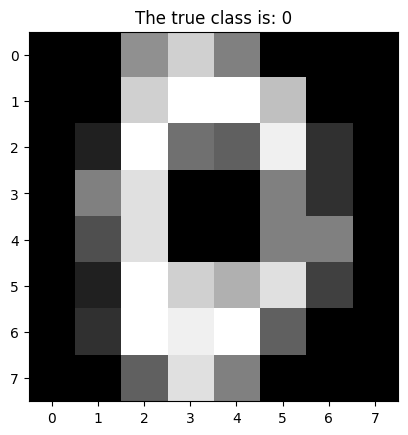

Prediction: [0]


In [265]:
# Essai de Prédiction
idx = random.randint(0, len(X_test))
plot_digit(idx, X=X_test, y=y_test)
print("Prediction:", clf.predict(pd.DataFrame([X_test.iloc[idx]])))

## Matrice de Confusion

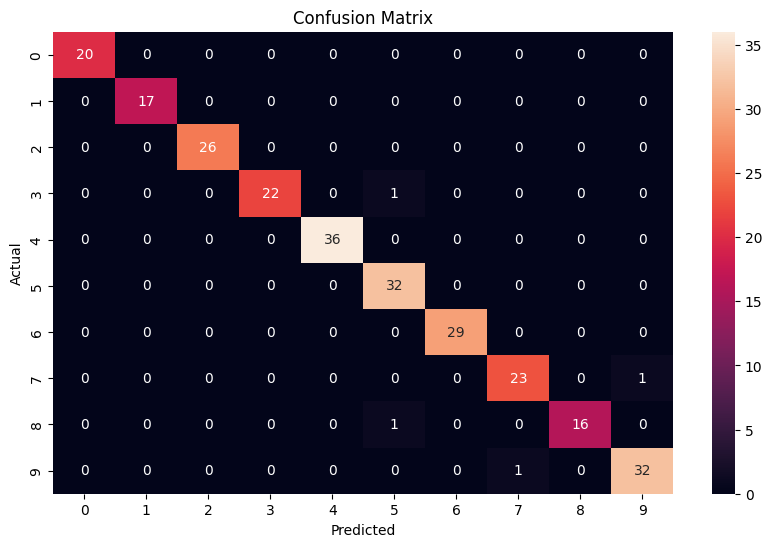

In [266]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(10,6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()